In [3]:
from pandas import read_csv

df = read_csv("steam_games_data.csv")
df

,name,steam_appid,short_description,detailed_description,recommendations,genres
0,Counter-Strike,10,Play the world's number 1 online action game. ...,Play the world's number 1 online action game. ...,162799,Action
1,Team Fortress Classic,20,One of the most popular online action games of...,One of the most popular online action games of...,6688,Action
2,Day of Defeat,30,Enlist in an intense brand of Axis vs. Allied ...,Enlist in an intense brand of Axis vs. Allied ...,4326,Action
3,Deathmatch Classic,40,Enjoy fast-paced multiplayer gaming with Death...,Enjoy fast-paced multiplayer gaming with Death...,2349,Action
4,Half-Life: Opposing Force,50,Return to the Black Mesa Research Facility as ...,Return to the Black Mesa Research Facility as ...,23052,Action
...,...,...,...,...,...,...
10875,Summer Crush,2163060,Summer Crush is a visual novel for adults wher...,"<span class=""bb_img_ctn""><video class=""bb_img""...",383,Indie
10876,Yet Another Zombie Survivors,2163330,The Horde is coming but you're ready to fight ...,"<p class=""bb_paragraph"" ><span class=""bb_img_c...",10989,"Action, Casual, Indie, RPG, Early Access"
10877,Tales of Spark,2165390,&quot;Tales of Spark&quot; is a Hack &amp; Sla...,"<h1>Development Plan</h1><p><span class=""bb_im...",554,"Action, Adventure, Indie, RPG, Early Access"
10878,Taora : Survival,2165470,Taora is an open world survival game with uniq...,"<span class=""bb_img_ctn""><img class=""bb_img"" s...",305,"Action, Adventure, RPG, Simulation, Early Access"


In [4]:
from sentence_transformers import SentenceTransformer

model_name = "all-MiniLM-L6-v2"
model = SentenceTransformer(model_name)
print(f"Loaded model: {model_name} (Vector dimension: {model.get_sentence_embedding_dimension()})")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Loaded model: all-MiniLM-L6-v2 (Vector dimension: 384)


In [5]:
genre_names = {"Indie", "Action", "Adventure", "Simulation", "RPG", "Strategy", "Casual"}

In [6]:
def construct_typical_genre_paragraph(genre_name: str) -> str:
	return f"This is a game of type '{genre_name.lower()}'."

In [7]:
genre_embeddings = {
	genre_name: model.encode(construct_typical_genre_paragraph(genre_name=genre_name), convert_to_numpy=True)
	for genre_name in genre_names
}

In [8]:
import numpy as np
from scipy.spatial.distance import cosine


def calculate_genre_cosine_distance(text: str, genre_embedding: np.ndarray) -> float:
	text_embedding = model.encode(text, convert_to_numpy=True)
	distance = cosine(text_embedding, genre_embedding)
	return distance

In [9]:
def extract_genre_features(game_row: dict, desc_column: str = "short_description") -> dict:
	features = {}
	description = game_row[desc_column]

	for genre_name, genre_embedding in genre_embeddings.items():
		desc_distance = calculate_genre_cosine_distance(description, genre_embedding)
		features[f"{genre_name.lower()}_cosine_distance"] = desc_distance

	return features

In [10]:
import matplotlib.pyplot as plt

def visualize_genre_features(short_desc_game_features: dict, detailed_desc_game_features: dict):
	short_desc_values = [short_desc_game_features[f"{genre_name.lower()}_cosine_distance"] for genre_name in genre_names]
	detailed_desc_values = [detailed_desc_game_features[f"{genre_name.lower()}_cosine_distance"] for genre_name in genre_names]
	data = [short_desc_values, detailed_desc_values]
	fig, ax = plt.subplots()
	cax = ax.matshow(data, cmap="Greys", vmin=0.5, vmax=0.95)

	ax.set_xticks(range(len(genre_names)))
	ax.set_xticklabels(list(genre_names))
	ax.set_yticks([0, 1])
	ax.set_yticklabels(["Short Description", "Detailed Description"])

	for (i, j), val in np.ndenumerate(data):
		ax.text(j, i, f"{val:.2f}", ha='center', va='center', color='black' if val < 0.6 else 'white')

	plt.colorbar(cax)
	plt.show()

In [11]:
def plot_for_game(game_idx: int) -> dict:
	game = df.iloc[game_idx]
	game_features = extract_genre_features(game_row=game)
	detailed_desc_game_features = extract_genre_features(game_row=game, desc_column="detailed_description")
	visualize_genre_features(short_desc_game_features=game_features, detailed_desc_game_features=detailed_desc_game_features)
	return game

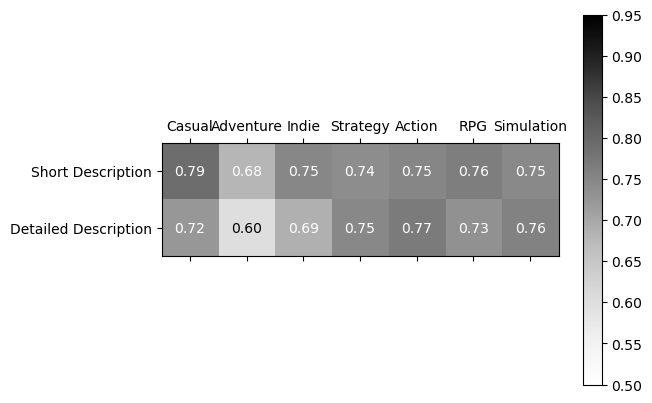

name                                                                Maize
steam_appid                                                        284240
short_description       Maize is a first-person adventure game about w...
detailed_description    <i>Maize</i> is a first-person adventure game ...
recommendations                                                       740
genres                                                   Adventure, Indie
Name: 1535, dtype: object

In [12]:
plot_for_game(1535)

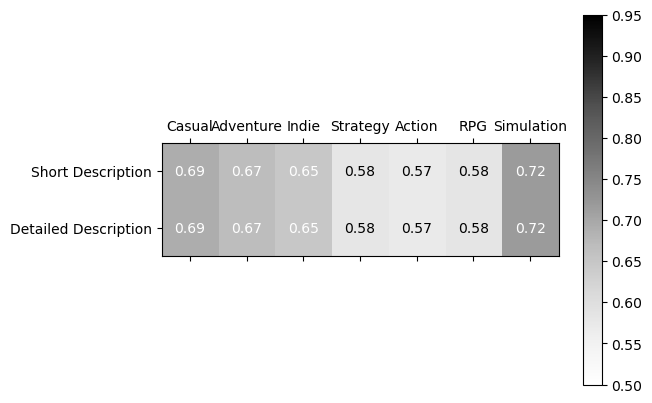

name                                                       Counter-Strike
steam_appid                                                            10
short_description       Play the world's number 1 online action game. ...
detailed_description    Play the world's number 1 online action game. ...
recommendations                                                    162799
genres                                                             Action
Name: 0, dtype: object

In [13]:
plot_for_game(0)

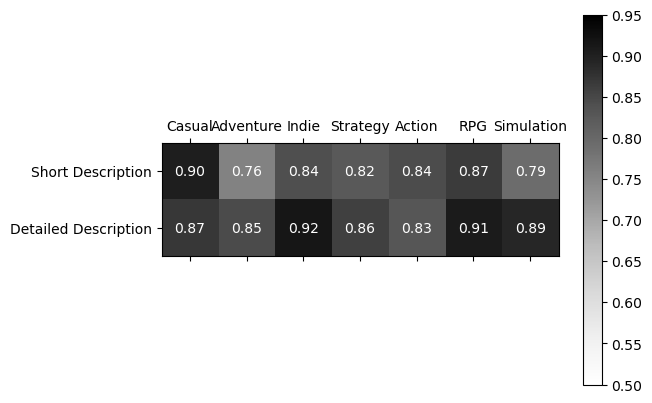

name                                                        Just Cause™ 3
steam_appid                                                        225540
short_description       With over 1000 km² of complete freedom from sk...
detailed_description    <h1>JUST CAUSE 4</h1><p><p class="bb_paragraph...
recommendations                                                    100727
genres                                                  Action, Adventure
Name: 1000, dtype: object

In [14]:
plot_for_game(1000)

In [17]:
import pandas as pd

df =pd.read_csv("steam_games_data_cleaned.csv")
df["embedding"] = [model.encode(desc) for desc in df["detailed_description"]]

In [18]:
import pickle

with open("steam_games_data_with_embeddings.pkl", "wb") as fp:
    pickle.dump(df, fp)